In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.linalg import fractional_matrix_power

## Exercise 2.1. Preprocessing.

### a) Load the dataset and compute the Principal Components.

In [198]:
def PC_sort(data):
    cov = np.cov(data)
    eig_val, eig_vec = np.linalg.eig(cov)
    idx = np.argsort(eig_val, axis = 0)[::-1]
    sorted_PC = eig_vec[:,idx].T
    return sorted_PC

[[ 0.88773892  0.46034728]
 [-0.46034728  0.88773892]]


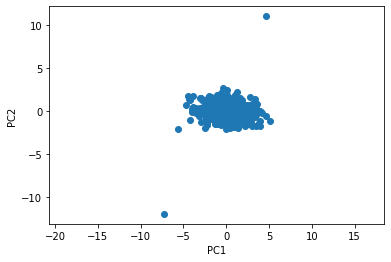

In [199]:
data2 = pd.read_csv('data/pca2.csv')
data_np = data2.values
data2c = (data_np - np.mean(data_np,axis=0)).T

PC2 = PC_sort(data2c)

pca_data_2d = PC2 @ data2c
plt.scatter(pca_data_2d[0],pca_data_2d[1]);

plt.axis('equal');
plt.xlabel('PC1')
plt.ylabel('PC2');
print(PC2)

### b) Remove observations 17 and 157 and redo the above.

[[ 0.93549122  0.35334993]
 [-0.35334993  0.93549122]]


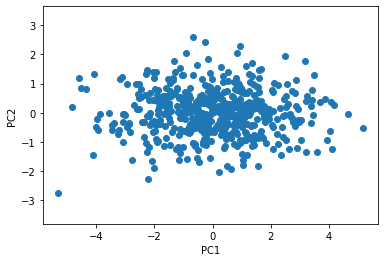

In [200]:
new_data2 = np.delete(data_np,[16,156],0)
new_data2c = (new_data2 - np.mean(new_data2,axis=0)).T

PCnew2 = PC_sort(new_data2c)

pca_new_data_2d = PCnew2 @ new_data2c
plt.scatter(pca_new_data_2d[0],pca_new_data_2d[1]);

plt.axis('equal');
plt.xlabel('PC1')
plt.ylabel('PC2');
print(PCnew2)

## 2.2. Whitening.

### a) Load the dataset "pca4.csv" and clean of outliers.

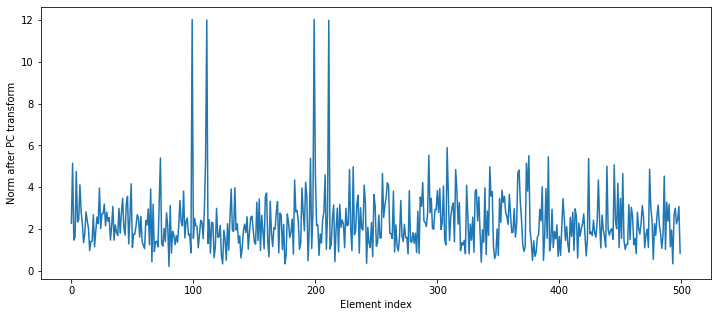

In [201]:
data4 = pd.read_csv('data/pca4.csv')
data4_np = data4.values
data4c = (data4_np - np.mean(data4_np,axis=0)).T

plt.figure(figsize=(12,5))
norms = np.linalg.norm(data4c,axis=0)
plt.plot(norms)
plt.xlabel('Element index')
plt.ylabel('Norm after PC transform')

idx = np.argwhere(norms>8)
new_data4c = np.delete(data4c,idx,1)

We can see that the norms of those data are far away from the others after centering the data: they can be determined to be outliers. Determining an heuristic of norm<8 can exclude those from the data.

### b) Perform PCA on a reasonable subset of this data.

In [202]:
def PC_allsort(data):
    cov = np.cov(data)
    eig_val, eig_vec = np.linalg.eig(cov)
    idx = np.argsort(eig_val, axis = 0)[::-1]
    sorted_PC = eig_vec[:,idx].T
    return sorted_PC,eig_val[idx],idx,cov

[[ 0.62542689  0.78026773  0.00100645  0.00473837]
 [ 0.7801957  -0.62540836 -0.00936694  0.00844494]
 [ 0.01040759 -0.00251568  0.14252724 -0.98973296]
 [ 0.00524905 -0.00635002  0.98974604  0.14260046]]


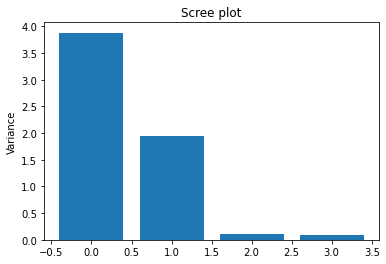

In [212]:
batch = new_data4c[:,0::2]

M,evals4,idx,cov = PC_allsort(batch)
ev_diag = np.diag(evals4)

plt.bar(idx,evals4)
plt.title('Scree plot')
plt.ylabel('Variance')

print(PCnew4)

### c) Whiten the data.

In [230]:
V = fractional_matrix_power(ev_diag, -0.5) @ M @ new_data4c
Means = np.mean(V,axis=1)
Std = np.std(V,axis=1)
print(Means,Std)

[ 0.0003592  -0.0003637   0.00024077 -0.00061291] [1.03402232 0.99968759 0.99924686 1.01949367]


### d) Generate heat plots.

#### (i) Covariance matrix.

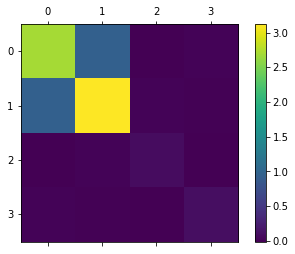

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov)
fig.colorbar(cax);

#### (ii) Covariance matrix of data projected.

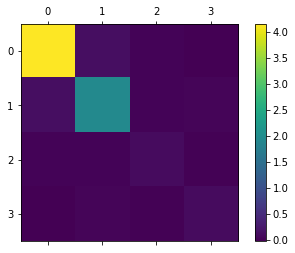

In [251]:
proj_data = M @ new_data4c
cov = np.cov(proj_data)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov)
fig.colorbar(cax);

#### (iii) Whitened variables.

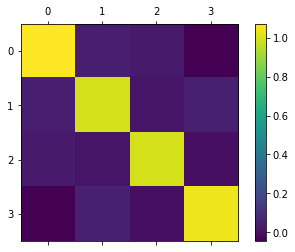

In [253]:
cov = np.cov(V)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov)
fig.colorbar(cax);

## 2.4. Oja's rule: Application.

In [263]:
data = pd.read_csv('data/data-onlinePCA.txt', delimiter=',').values[:,1:3]

### a) Produce scatter plot.

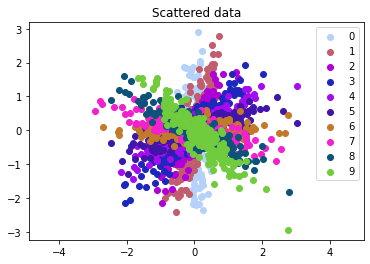

In [358]:
fig = plt.figure()
block = np.int(data.shape[0]/10)
t_blocks = np.empty((10,2,block))
color =''
    
for i in range(0,10):
    c='#%06X' % np.random.randint(0, 0xFFFFFF)
    color += c
    t_blocks[i,:,:] = np.vstack((data[(i*block):(i*block+block),0],data[(i*block):(i*block+block),1]))
    plt.scatter(t_blocks[i,0,:],t_blocks[i,1,:],c=c,label=str(i))
    plt.axis('equal');
    
plt.legend()
plt.title('Scattered data');

### b) Determine PCs and plot them.

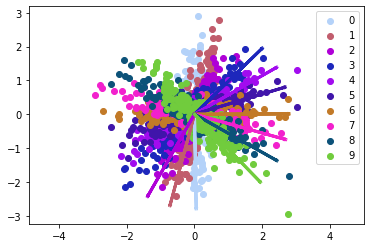

In [359]:
PCs = np.empty((2,2,10))

for i in range(0,10):
    PCs[:,:,i] = PC_sort(t_blocks[i,:,:]) 
    plt.arrow(0, 0, PCs[0,0,i]*2.8, PCs[0,1,i]*2.8, color=color[7*i:7*i+7], linewidth=3)
    plt.scatter(t_blocks[i,0,:],t_blocks[i,1,:],c=color[7*i:7*i+7],label=str(i))
    plt.legend()
    plt.axis('equal');

### c) Implement Oja's rule.

In [403]:
learn_rate = np.array([0.002,0.04,0.45])
weights = np.empty((3,2000,2))

for i, learn in enumerate(learn_rate):
    new_w = np.random.normal(0,1,2)
    new_w /= np.linalg.norm(new_w)
    
    for j,x in enumerate(data):
        y = new_w @ x.T
        new_w = new_w + learn*y*(x - y * new_w)
        weights[i,j,:] = new_w

Text(0.5, 0, 'Time (s)')

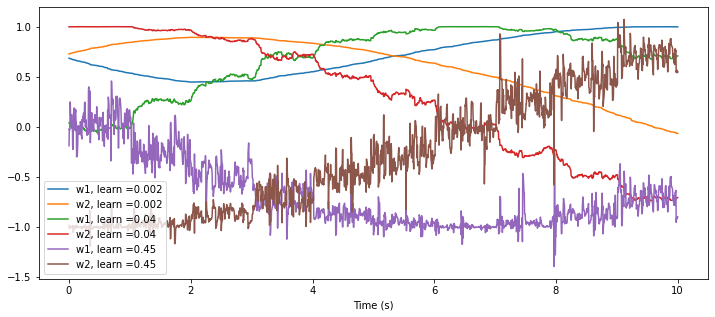

In [426]:
t = np.linspace(0,10,weights.shape[1])
plt.figure(figsize=(12,5))

for i,l in enumerate(learn_rate):
    plt.plot(t,weights[i,:,0],label=f'w1, learn ={l}')
    plt.plot(t,weights[i,:,1],label=f'w2, learn ={l}')

plt.legend()
plt.xlabel('Time (s)');

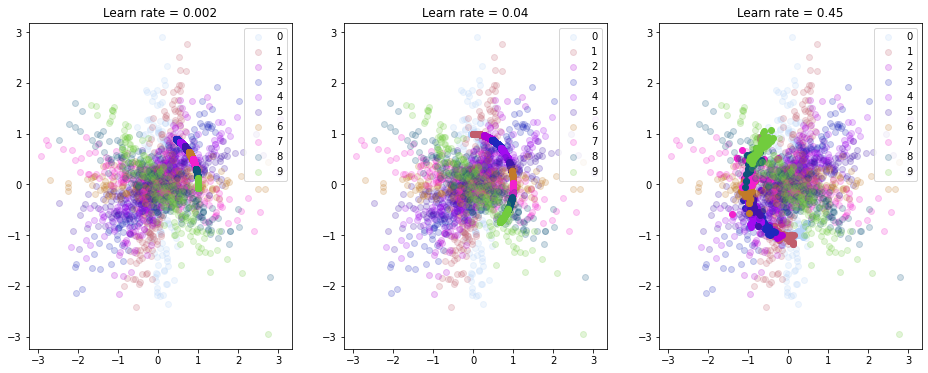

In [440]:
fig = plt.figure(figsize=(16,6))

for j,learn in enumerate(learn_rate):
    fig.add_subplot(1,3,j+1)
    plt.title(f'Learn rate = {learn}')
    for i in range(0,10):
        plt.scatter(weights[j,(i*block):(i*block+block),0],weights[j,(i*block):(i*block+block),1],c=color[7*i:7*i+7])
        plt.scatter(t_blocks[i,0,:],t_blocks[i,1,:],c=color[7*i:7*i+7],label=str(i),alpha=0.2)
        plt.legend()